In [1]:
import sys
sys.path.append("/home/huaqingj/MyResearch/TVDN")

In [2]:
from pyTVDN.TVDNutils import *
from pyTVDN import TVDNDetect
from pyTVDN.tmpUtils import *
from pathlib import Path
from scipy.io import loadmat
from scipy.signal import detrend
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from collections import defaultdict as ddict
from tqdm import tqdm
import pickle
from scipy.signal import lfilter, firls, decimate
from numpy.linalg import inv, svd
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
plt.rcParams["axes.edgecolor"] = "0.3"
#plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams['axes.labelcolor']='black'

In [3]:
saveDir = Path("../results/fMRIHPFs_sep")
fil = list(saveDir.glob("*healthy.pkl"))[0]
print(fil)

with open(fil, "rb") as f:
    TVDNres = pickle.load(f)

../results/fMRIHPFs_sep/fMRIResultAdap_healthy.pkl


In [4]:
import rpy2.robjects as robj
robj.r.source("../Rcode/utils.R")

RsegCorr = robj.r["segCorr"]
RsegPCA = robj.r["segPCA"]
RsegDMD = robj.r["DMD"]
RchgF = robj.r["chgF"]

In [5]:
flag = 0
for DetObj in tqdm(TVDNres.DetObjs):
    time = DetObj.time
    Xmat = DetObj.Xmat
    dXmat = DetObj.dXmat
    downrate = 1
    fct = DetObj.paras.fct
    h = bw_nrd0_R(time, fct=fct)
    d, n = Xmat.shape
    Amats = []
    for s in time[::downrate]:
        t_diff = time - s
        kernels = 1/np.sqrt(2*np.pi) * np.exp(-t_diff**2/2/h**2) # normal_pdf(x/h)
        kernelroot = kernels ** (1/2)
        kerdXmat = kernelroot[:, np.newaxis] * (dXmat.T) # n x d
        kerXmat = kernelroot[:, np.newaxis] * (Xmat.T) # n x d
        M = kerXmat.T.dot(kerXmat)/n
        XY = kerdXmat.T.dot(kerXmat)/n
        U, S, VT = svd(M)
        r = np.argmax(np.cumsum(S)/np.sum(S) >= 0.999) + 1 # For real data
        invM = U[:, :r].dot(np.diag(1/S[:r])).dot(VT[:r, :])
        Amat =  XY.dot(invM)
        Amats.append(Amat)
    

    with open(f"../NeuroImgR1/fMRI_Amatss/fMRI_Amats_idx{flag}.pkl", "wb") as f:
        pickle.dump(Amats, f)
    flag += 1

100%|██████████| 103/103 [00:47<00:00,  2.19it/s]


In [5]:
Nrep = 100
errsH0s = []
errH11s = []
errH12s = []
for DetObj in tqdm(TVDNres.DetObjs):
    dXmat = DetObj.dXmat
    Xmat = DetObj.Xmat
    Ymat = DetObj.nYmat
    d, n = Ymat.shape
    ecpts = DetObj.ecpts
    ndXmat = DetObj.midRes.ndXmat
    nXmat = DetObj.midRes.nXmat
    eigVecs = DetObj.midRes.eigVecs
    r = DetObj.paras.r
    tStep = np.diff(DetObj.time)[0]
    paras = DetObj.paras
    time = DetObj.time
    predIdxs = np.delete(np.arange(n), trainIdxFn(ecpts, n))
    
    errsH0 = []
    for jj in range(Nrep):
        YmatPred = ReconXmatSWHalfH0(ecpts, dXmat, Xmat, Ymat, time, rate=1, is_full=True)
        YmatPred = YmatPred.EstXmatRealOrg
        diffPred = Ymat - YmatPred
                
        YPart = Ymat[:, predIdxs]
        YpredPart = YmatPred[:, predIdxs]
        pdiff = YPart - YpredPart
        # error under non random 
        err = np.sqrt((pdiff**2).sum(axis=0)/(YPart**2).sum(axis=0)).mean()
        errsH0.append(err)
        
    errsH0s.append(errsH0)
    
    YmatPred = ReconXmatSWHalf2(ecpts, dXmat, Xmat, Ymat, DetObj.time, rate=1, is_full=True)
    YmatPred = YmatPred.EstXmatRealOrg
    diffPred = Ymat - YmatPred
            
    YPart = Ymat[:, predIdxs]
    YpredPart = YmatPred[:, predIdxs]
    pdiff = YPart - YpredPart
    errH12 = np.sqrt((pdiff**2).sum(axis=0)/(YPart**2).sum(axis=0)).mean()
    errH12s.append(errH12)

100%|██████████| 103/103 [02:43<00:00,  1.64s/it]


In [7]:
pVals = []
for errH12, errsH0 in zip(errH12s, errsH0s):
    pVal = np.mean(np.array(errsH0) <= errH12)
    pVals.append(pVal)

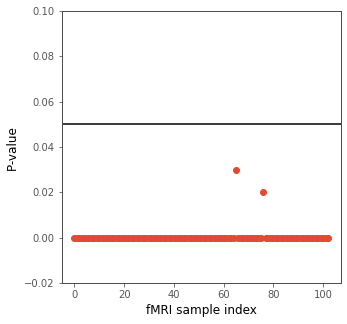

In [10]:
plt.figure(figsize=[5, 5])
plt.plot(pVals, "o")
plt.axhline(y = 0.05, color="black")
plt.ylim([-0.02, 0.1])
plt.xlabel("fMRI sample index")
plt.ylabel("P-value ")
plt.savefig("./plots/fMRI_test_pvalue.jpg",  bbox_inches='tight')